# Tutorial #5 Visualizing Gaussian Process Realizations

The purpose of thise notebook is to look at the output from the noise analysis and try to understand various aspects of what the model selection and data are telling us. 

In [1]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import numpy as np
import json, pickle, copy

In [2]:
import la_forge.diagnostics as dg
import la_forge.core as co
from la_forge.rednoise import plot_rednoise_spectrum, plot_free_spec
from la_forge.utils import epoch_ave_resid

### Load Chains

You'll want to point to the chains for the pulsar you wish to investigate.

In [3]:
psrname = 'J1713+0747'
chaindir = '/Users/hazboun/software_development/la_forge/tests/data/chains/adv_noise_J1713+0747/'

Here we load up a set of chains from an `enterprise.hypermodel.HyperModel` analysis. 

In [4]:
cH=co.HyperModelCore(label='PSR {}, DM Model Selection',
                     chaindir=chaindir)

The `HyperModelCore.model_core` method returns only the samples, and paranmeters, for one particular model. 

In [5]:
c0=cH.model_core(0)

# Gaussian Process Realizations

Most of the advanced noise models that we are unleashing on ur various pulsars are various iterations of Gaussian processes. These are meant to model stochastic processes in data and while there are often functions that are used to describe them, they are inherently realization dependent. In order to get a feeling for how well the GPs are fitting the data we use `enterprise` to make realizations of the GPs. Thankfully this is straightofrward using the the various tools available. 

We start by importing a few functions, retrieving the pulsar and making the PTA object. 

In [6]:
from enterprise_extensions.models import model_singlepsr_noise

In [7]:
from la_forge.gp import Signal_Reconstruction as gp

In [8]:
filepath = '/Users/hazboun/nanograv_detection/12p5yr/noise_model_selection/'
filepath += '{0}_ng12p5yr_v3_nodmx_ePSR.pkl'.format(psrname)

In [9]:
with open(filepath,'rb') as fin:
    psr=pickle.load(fin)

with open(chaindir+'/model_kwargs.json' , 'r') as fin:
    model_kwargs=json.load(fin)

You shouldn't need this next cell, but there are some of the original model_kwarg dictionaries with spurious entries that need to be deleted. If you get an error when calling `model_singlepsr_noise` and it matches one of the these kwargs, try running this cell to delete them.

In [10]:
pta = model_singlepsr_noise(psr, **model_kwargs['0'])

In [11]:
len(pta.param_names), len(c0.params[:-4])

(41, 41)

The `Signal_Reconstruction` class take an `enterprise.pulsar.Pulsar` object, an `enterprise.signal_base.PTA` object and a `la_forge.core.Core` object as inputs. (One can alternatively use a chain array and burn value for the latter.) 

In [12]:
sr=gp(psr, pta, core=c0)

The `gp_types` atribute will tell you which Gaussian process signals are available in this `PTA`. Additionally there are a number of other options one can use for the `gp_type` flag that goes into a signal reconstruction. These include `['achromatic_rn','DM','FD','all']`. Also any of the timing parameter perturbations can also be called. 

In [13]:
sr.gp_types

['linear_timing_model', 'red_noise', 'dm_gp', 'chrom_gp']

Every pulsar has a list of the timing parameters that are fit with the linearized timing model. These are also modeled as Gaussian process and can be retrieved with the same functions.

In [14]:
psr.fitpars 

['Offset',
 'ELONG',
 'ELAT',
 'F0',
 'F1',
 'DM',
 'DM1',
 'DM2',
 'PMELONG',
 'PMELAT',
 'PX',
 'PB',
 'T0',
 'A1',
 'OM',
 'ECC',
 'M2',
 'FD1',
 'FD2',
 'FD3',
 'FD4',
 'FD5',
 'KOM',
 'KIN',
 'JUMP1',
 'JUMP2',
 'JUMP3']

In [15]:
# parameter indices to pull from chain. Change `size` flag for more or less.
# first one picks the "most likely values"
idxs = np.argsort(c0.get_param('lnpost',to_burn=False))[::-1][:20]

# this one just picks random values. Should be broadly the same as above if well converged
# idxs = np.random.randint(sr.burn, sr.chain.shape[0],size=100)

### The `reconstruct_signal` method
There are few useful options for regaining GPs using this method. Here is the docstring:

```
Parameters
----------
gp_type : str, {'achrom_rn','gw','DM','none','all',timing parameters}
    Type of gaussian process signal to be reconstructed. In addition
    any GP in `psr.fitpars` or `Signal_Reconstruction.gp_types` may be
    called.
    ['achrom_rn','red_noise'] : Return the achromatic red noise.
    ['DM'] : Return the timing-model parts of dispersion model.
    [timing parameters] : Any of the timing parameters from the linear
        timing model. A list is available as `psr.fitpars`.
    ['timing'] : Return the entire timing model.
    ['gw'] : Gravitational wave signal. Works with common process in
        full PTAs.
    ['none'] : Returns no Gaussian processes. Meant to be used for
        returning deterministic signal.
    ['all'] : Returns all Gaussian processes.

det_signal : bool
    Whether to include the deterministic signals in the reconstruction.

mlv : bool
    Whether to use the maximum likelihood value for the reconstruction.

idx : int, optional
    Index of the chain array to use.
```

In particular you can choose which GP signals to return. To return a single gp choose from the list `sr.gp_types`. If you want the dispersion measure elements of the DM model you can use `'DM'`. This returns either the DMX GP or the DM1 and DM2 GPs. 

To get all of the deterministic signals, but no GP use `reconstruct_signal(gp_type='none',det_signal=True, ...)`.

The next cell gives the timing model components of the dispersion model + any deterministic models (DM, CW, ...). The only determinsitic model this pulsar has is the solar wind, but if you add DM dips or something this is the flag to use. You get all of them at the same time. One can construct these signals separately but it would take different code.

In [16]:
DM = np.array([sr.reconstruct_signal(gp_type='DM',det_signal=True, idx=idx)[psrname]
               for idx in idxs])

The next three cells return realizations of the DM GP and the Chromatic GP. 

In [17]:
dm_gp = np.array([sr.reconstruct_signal(gp_type='dm_gp', idx=idx)[psrname]
                  for idx in idxs])

In [18]:
chrom_gp = np.array([sr.reconstruct_signal(gp_type='chrom_gp', idx=idx)[psrname]
                    for idx in idxs])

In [19]:
mn_DM = np.mean(DM,axis=0)
mn_dmgp = np.mean(dm_gp,axis=0)
mn_chrom_gp = np.mean(chrom_gp,axis=0)

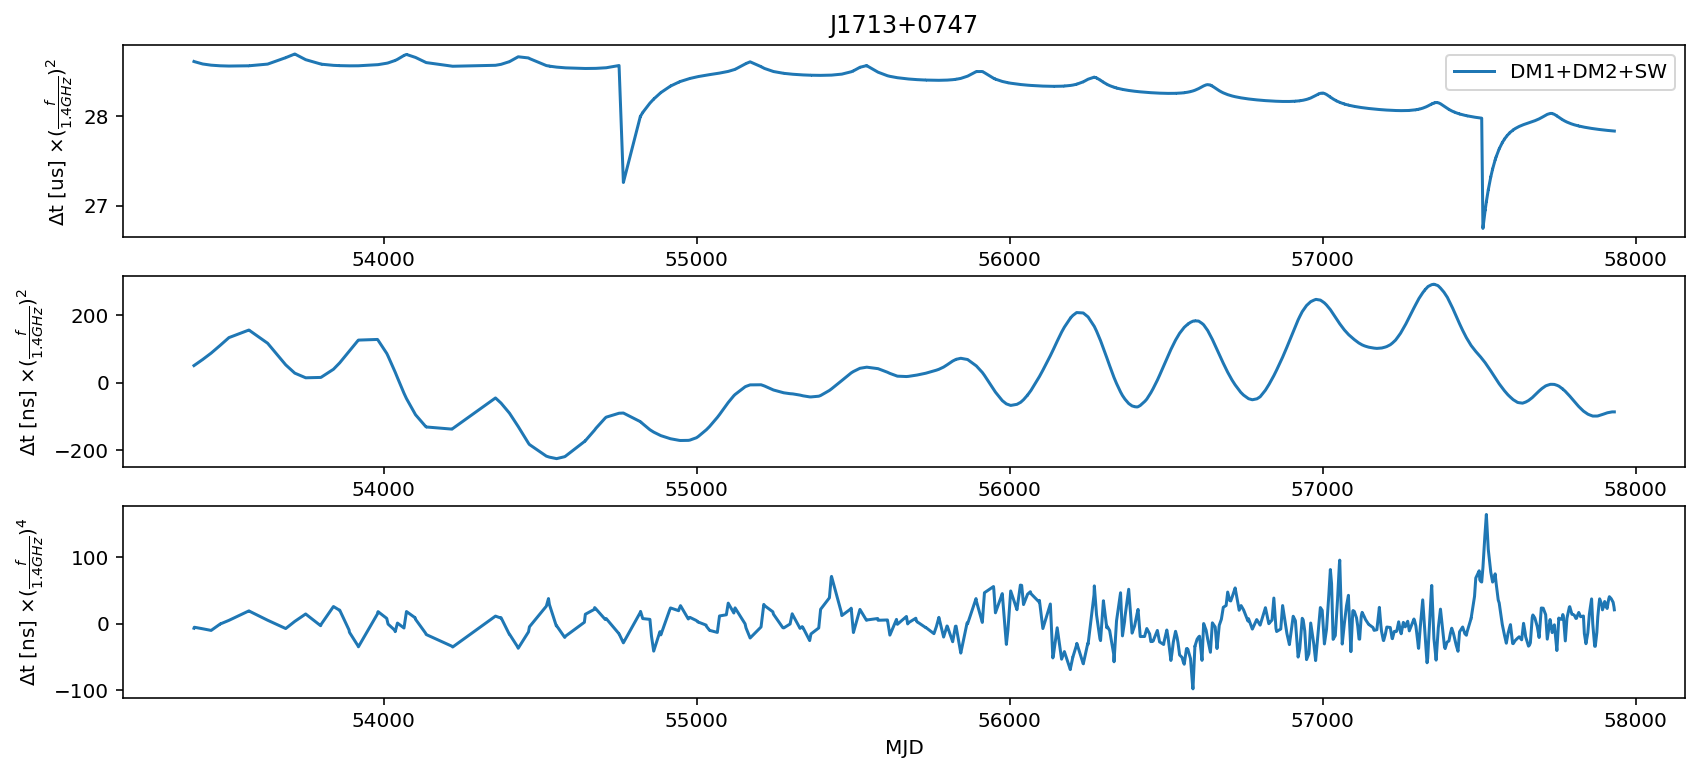

In [20]:
fig = plt.figure(figsize=[14,6])

####### First Plot ########
fig.add_subplot(311)
plt.plot(psr.toas/(24*3600),mn_DM*(psr.freqs/1400)**2*1e6,label='DM1+DM2+SW')
plt.legend()
plt.ylabel(r'$\Delta$t [us] $\times (\frac{f}{1.4 GHz})^2$')
plt.title(psrname)

####### Second Plot ########
fig.add_subplot(312)
plt.plot(psr.toas/(24*3600),mn_dmgp*(psr.freqs/1400)**2*1e9,label='DM GP 1')
plt.ylabel(r'$\Delta$t [ns] $\times (\frac{f}{1.4 GHz})^2$')

####### Third Plot ########
fig.add_subplot(313)
plt.plot(psr.toas/(24*3600),mn_chrom_gp*(psr.freqs/1400)**4*1e9,label='Chrom GP')
plt.ylabel(r'$\Delta$t [ns] $\times (\frac{f}{1.4 GHz})^4$')
plt.xlabel('MJD')
plt.show()

## Plot DMX
Use the DMX values from the data release as a comparison of how well the DM GP models are matching the changes in the dispersion measure.

In [21]:
#Load DMX values
dtypes = {'names': ('DMXEP', 'DMX_value', 'DMX_var_err', 
                    'DMXR1', 'DMXR2', 'DMXF1', 
                    'DMXF2', 'DMX_bin'),
          'formats': ('f4','f4','f4','f4','f4','f4','f4','U6')}
dmx = np.loadtxt('/Users/hazboun/nanograv_detection/12p5yr/noise_model_selection/dmx/{0}_NANOGrav_12yv3.dmx'.format(psrname),
                 skiprows=4,
                 dtype=dtypes)

In [22]:
# Convert signals into units of DM [pc/cm^3]
dm_units = (dm_gp  + DM)*psr.freqs[np.newaxis,:]**2*2.41e-4 
dm_mean = (mn_DM + mn_dmgp )*psr.freqs**2*2.41e-4

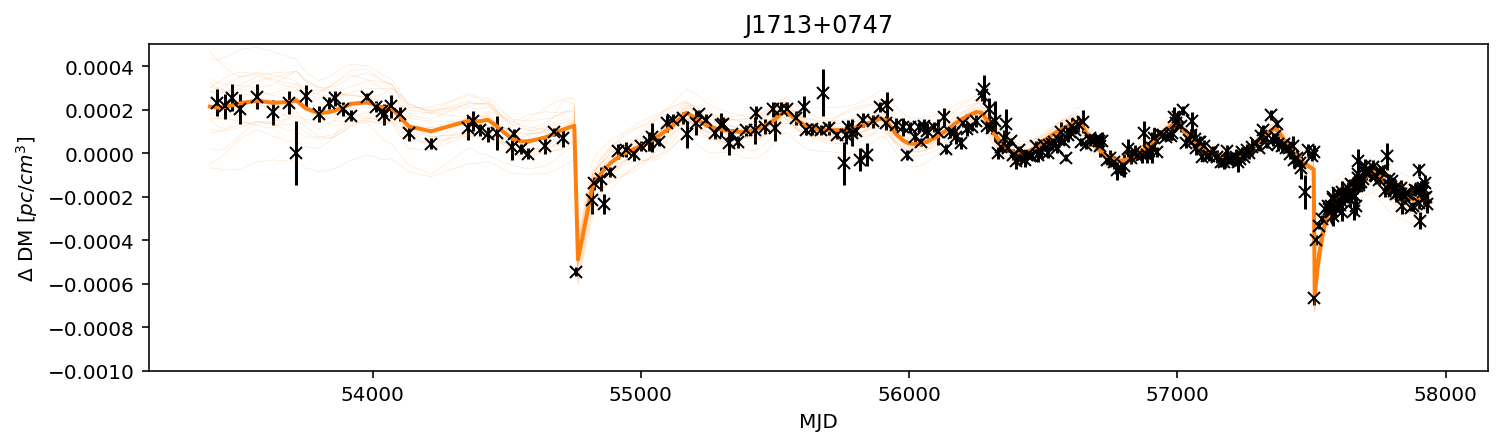

In [23]:
plt.figure(figsize=[12,3])
for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mean-dm_mean.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')


plt.ylim(-0.0010,0.0005)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')
plt.title(psrname)
plt.show()

## Looking at Residuals

Uncorrected residuals will look really bad since we have stripped all of the DMX parameters and DM1/DM2 are set to zero initially. 

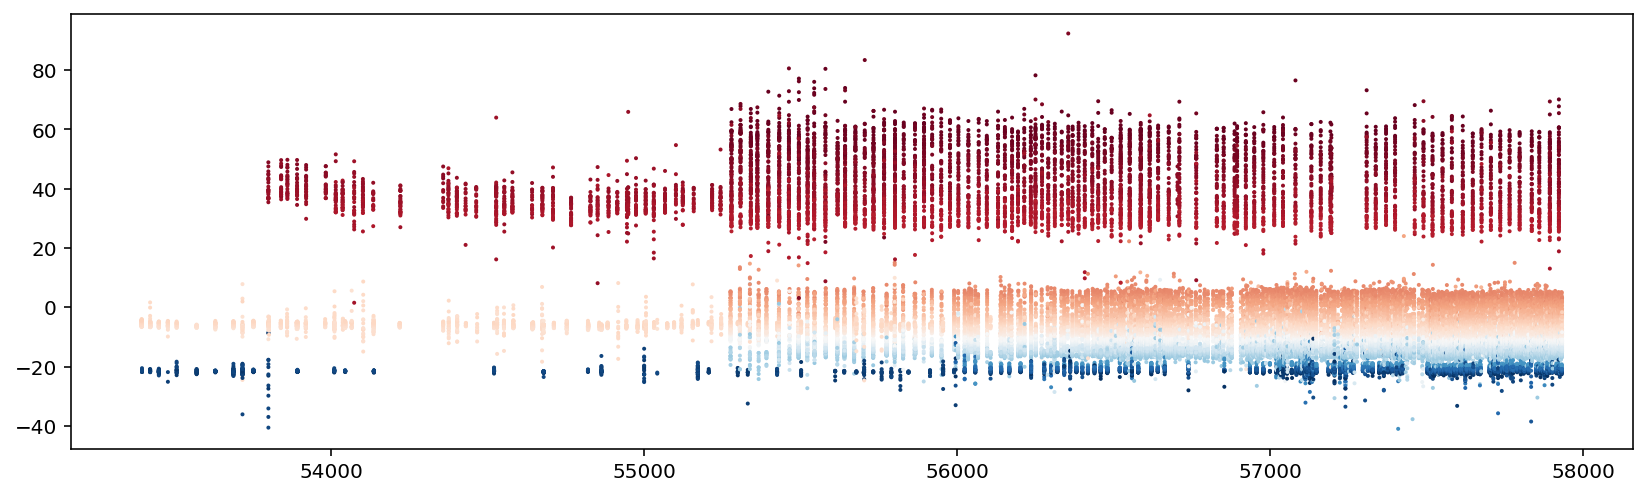

In [24]:
sec_to_day = 24*3600
plt.figure(figsize=[14,4])
plt.scatter(x=psr.toas/sec_to_day,
            y=(psr.residuals)*1e6,
            s=1,
            c=psr.freqs,cmap='RdBu')
# plt.xlim(57000,58000)
plt.show()

The GPs are natively returned as delays in seconds so we can subtract them from the residuals to see what residuals `Enterprise` is actually calculating during the analysis. The following function calculates the epoch averaged TOAs after subtracting the given `correction` GPs. 

In [25]:
resids,msks=epoch_ave_resid(psr, correction= mn_DM + mn_dmgp + mn_chrom_gp) #This is all the chromatic GPs, DM1/DM2 + DMGP + ChromGP

This shows the two masks created for the different receivers. This allows us to plot by frequency.

In [26]:
masks = list(msks.keys())
masks

['Rcvr_800', 'Rcvr1_2', 'L-wide', 'S-wide']

In [27]:
all_chrgp = mn_DM + mn_dmgp + mn_chrom_gp

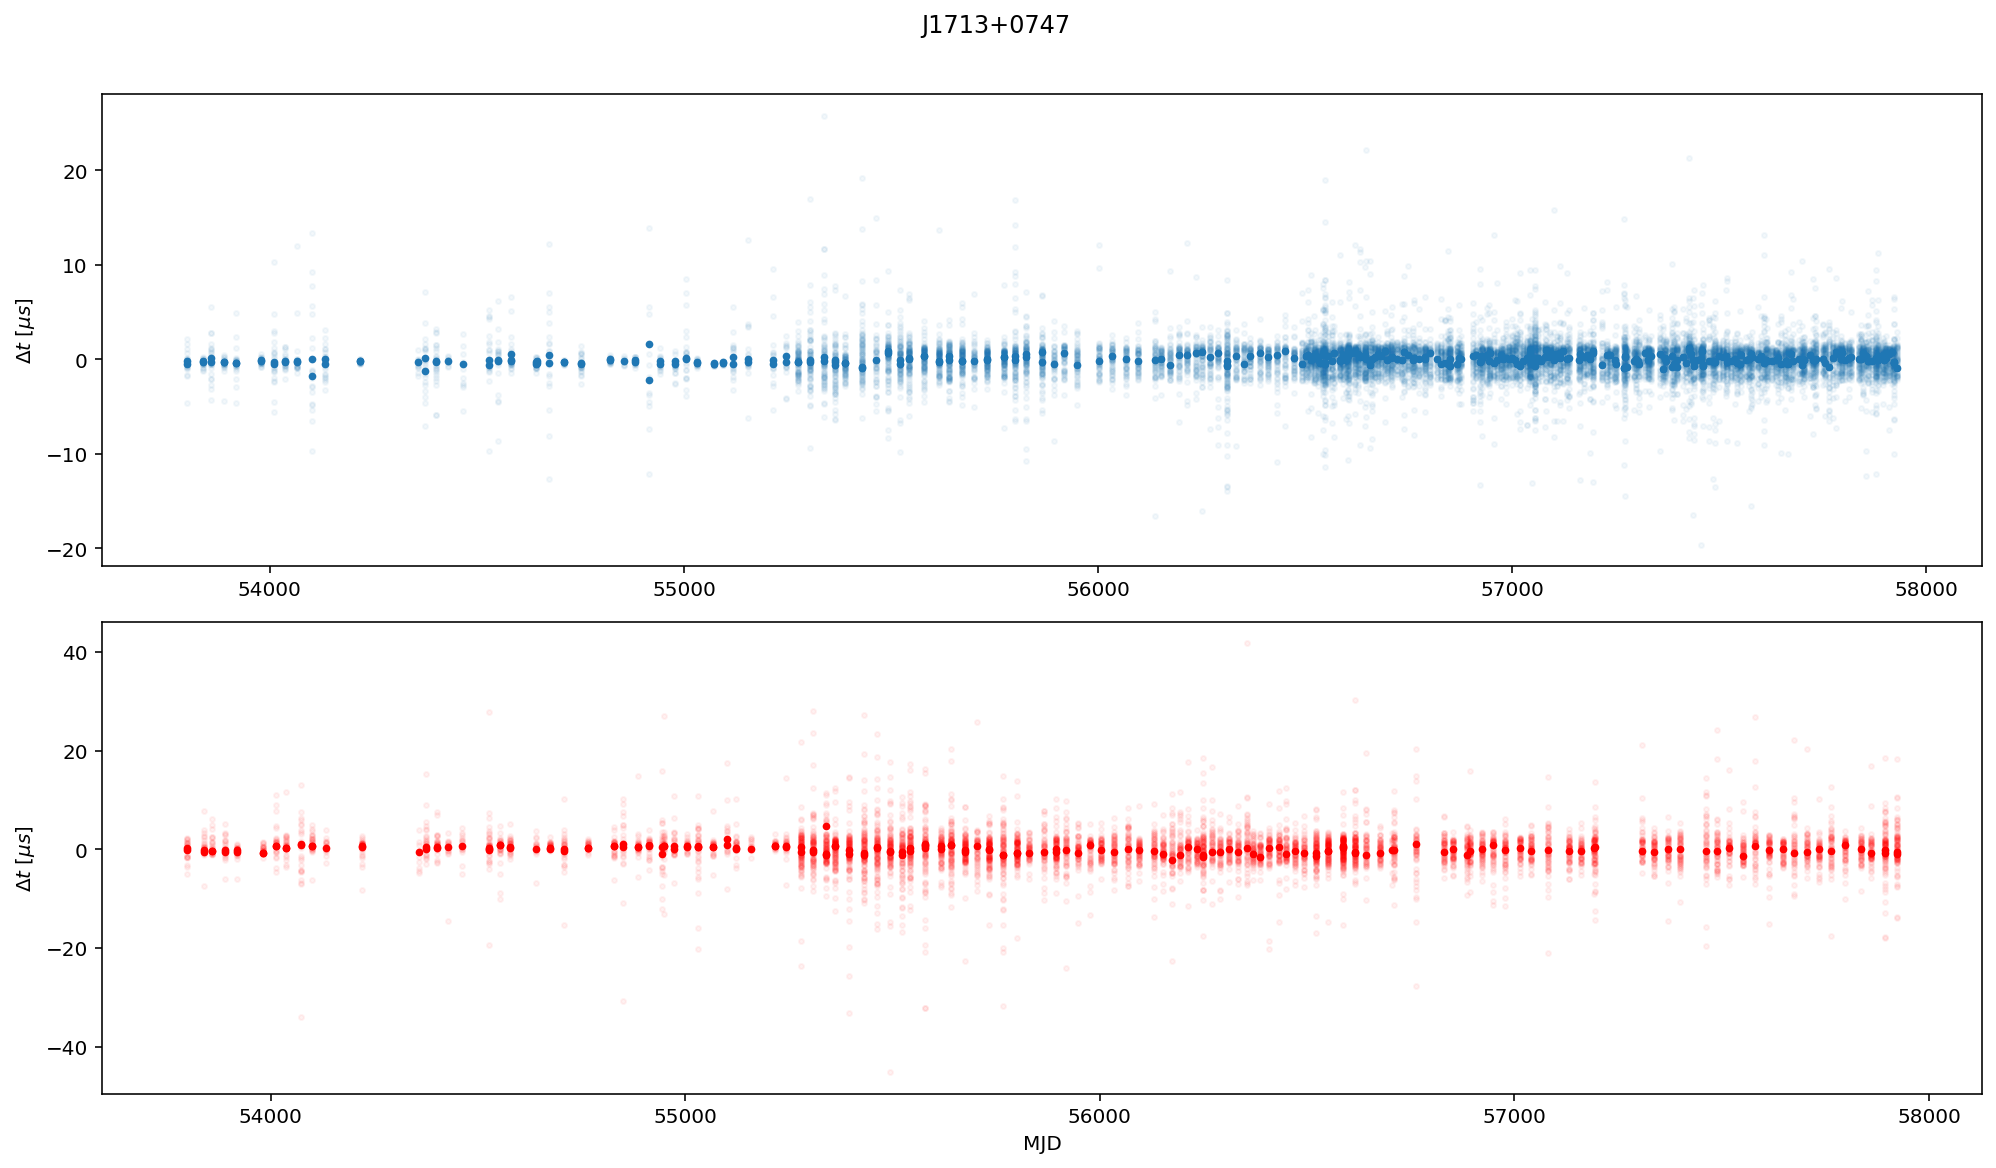

In [28]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,8])

#--------- 1st Plot -------------#
fig.add_subplot(211)
high_rec = 'Rcvr1_2'

plt.scatter(x=resids[high_rec][:,0]/sec_to_day,
            y=resids[high_rec][:,1]*1e6-np.mean(resids[high_rec][:,1]*1e6),
            s=8,c='C0')
plt.scatter(x=psr.toas[msks[high_rec]]/sec_to_day,
            y=((psr.residuals-all_chrgp)[msks[high_rec]]-(psr.residuals-all_chrgp)[msks[high_rec]].mean())*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylabel(r'$\Delta t$ [$\mu s$]')

#--------- 2nd Plot -------------#
fig.add_subplot(212)
low_rec = 'Rcvr_800'
plt.scatter(x=resids[low_rec][:,0]/sec_to_day,
            y=resids[low_rec][:,1]*1e6-np.mean(resids[low_rec][:,1]*1e6),
            s=8, c='red')
plt.scatter(x=psr.toas[msks[low_rec]]/sec_to_day,
            y=((psr.residuals-all_chrgp)[msks[low_rec]]-(psr.residuals-all_chrgp)[msks[low_rec]].mean())*1e6,
            s=6,
            c='red',alpha=0.05)#psr.freqs,cmap='RdBu')

plt.ylabel(r'$\Delta t$ [$\mu s$]')
plt.xlabel('MJD')
fig.suptitle(psrname,y=1.01)
fig.tight_layout()
plt.show()

Here we just plot the residuals along with the scattering GP to see if there is interesting that is missed by the current modeling. 

In [29]:
everything = np.array([sr.reconstruct_signal(gp_type='all',det_signal=True, idx=idx)[psrname] for idx in idxs])

In [30]:
mn_all = np.mean(everything, axis=0)

In [31]:
resids2,msks=epoch_ave_resid(psr, correction= mn_all) #This is all te chromatic GPs, DM1/DM2 + DMGP + ChromGP

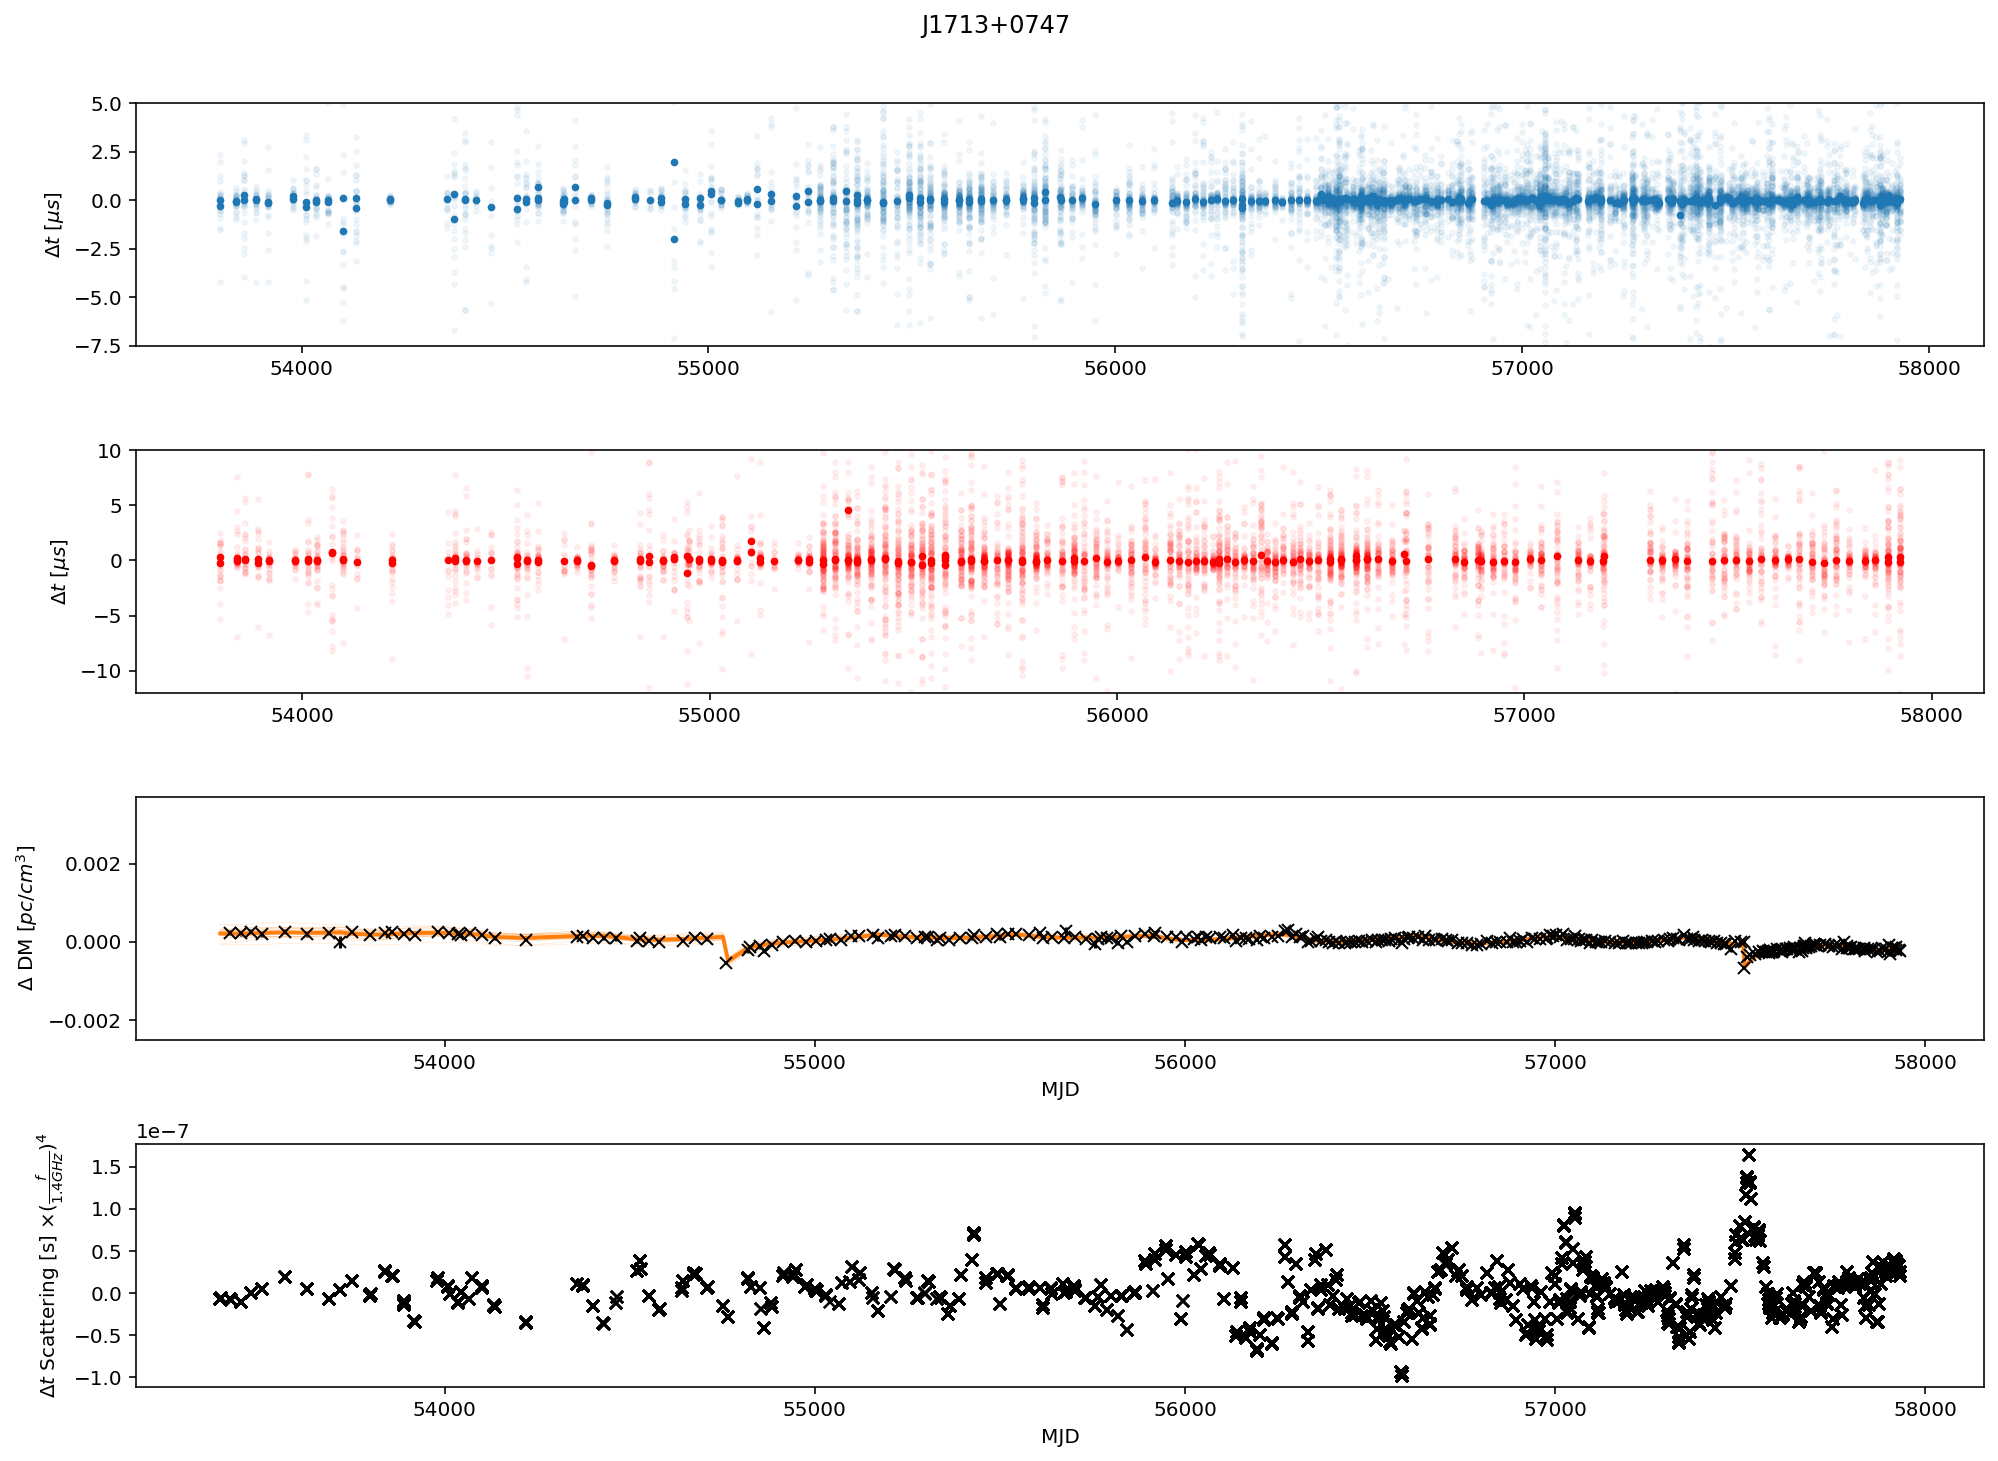

In [32]:
sec_to_day = 24*3600
fig=plt.figure(figsize=[14,10])
fig.add_subplot(411)
plt.scatter(x=resids2['Rcvr1_2'][:,0]/sec_to_day,
            y=resids2['Rcvr1_2'][:,1]*1e6,
            s=8,c='C0')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr1_2']/sec_to_day,
            y=(psr.residuals-mn_all)[psr.flags['fe']=='Rcvr1_2']*1e6,
            s=6,
            c='C0',alpha=0.05)
plt.ylim(-7.5,5)
plt.ylabel(r'$\Delta t$ [$\mu s$]')

fig.add_subplot(412)

plt.scatter(x=resids2['Rcvr_800'][:,0]/sec_to_day,
            y=resids2['Rcvr_800'][:,1]*1e6,
            s=8,c='red')
plt.scatter(x=psr.toas[psr.flags['fe']=='Rcvr_800']/sec_to_day,
            y=(psr.residuals-mn_all)[psr.flags['fe']=='Rcvr_800']*1e6,
            s=6,
            c='red',alpha=0.05)
plt.ylim(-12,10)

plt.ylabel(r'$\Delta t$ [$\mu s$]')

fig.add_subplot(413)

for dm in dm_units:
    plt.plot(psr.toas/(24*3600),dm-dm.mean(),linewidth=0.2,alpha=0.3,color='C1')

plt.plot(psr.toas/(24*3600),dm_mean-dm_mean.mean(),linewidth=2,color='C1')
plt.errorbar(x=dmx['DMXEP'],
             y=dmx['DMX_value']-dmx['DMX_value'].mean(),
             yerr=dmx['DMX_var_err'],
             marker='x',color='k',linestyle='none')

plt.ylim(-0.0025,0.0037)
plt.xlabel('MJD')
plt.ylabel(r'$\Delta$ DM [$pc/cm^3$]')

fig.add_subplot(414)
plt.plot(psr.toas/sec_to_day, mn_chrom_gp*(psr.freqs/1400)**4,'x',color='k')
plt.ylabel(r'$\Delta t$ Scattering [s] $\times (\frac{f}{1.4GHz})^4$')
plt.xlabel('MJD')

fig.suptitle(psrname,y=1.01)
fig.tight_layout(pad=1.01)
plt.show()